# Function Approximation in RL : LSTD(lambda)

**Due date : 20/03/2018**

**By : Julien Roy and David Kanaa**

In [1]:
import gym
import time

import numpy as np
import pycolab

from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

Least Squares Temporal Difference methods[2] (LSTD) allow to make better use of the training data than simpler TD learning methods at the cost of additional computation. However, in many setups, these additional computations are worth it as LSTD will converge faster overall than TD methods. The LSTD($\lambda$) algorithm from Boyan[1] adds eligibility traces to this process, allowing to choose the amount of bootstrapping to be used.

In this work, we implement two versions of this algorithm : an off-line version (complexity $O(n^3)$ in space) and a recursive version inspired by Bradtke and Barto [2] (complexity $O(n^2)$ in space). Those two algorithms are tested in two simple environments : the 13-states Boyan's Chain [1] and the 5-states Bradtke's Domain [2]. Finally, we empirically validate a proof made in Boyan's paper demonstrating that when $\lambda=1$, LSTD($\lambda$) is equivalent to supervised learning using a least squared error loss and sampled Monte-Carlo trajectories.

[1] : Bradtke, S. J., & Barto, A. G. (1996). Linear least-squares algorithms for temporal difference learning. Machine learning, 22(1-3), 33-57.

[2] : Boyan, J. A. (2002). Technical update: Least-squares temporal difference learning. Machine Learning, 49(2-3), 233-246.

# Implementations

In [2]:
def show_board(obs, board_footprints=None, leave_footprints=False):
    
    # Represents the agent as a yellow dot on the board
    board = 100 * np.array(obs.layers['P'], dtype=np.float)
    
    # Indicates in which states the agent went
    if leave_footprints:
        new_footprints = 20 * np.array(obs.layers['P'], dtype=np.float)
    
        if board_footprints is not None:
            board_footprints += new_footprints
            board += board_footprints
        else:
            board_footprints = new_footprints
    
    # Adds the Goal as a green dot on the board (if there is one)
    if 'G' in obs.layers:
        board += 80 * np.array(obs.layers['G'], dtype=np.float)

    # Creates the figure
    plt.figure(figsize=5 * np.array(board.shape))
    plt.imshow(board)
    plt.axis('off')
    plt.show()
    
    return board_footprints

### Environment - Boyan's Chain

In [3]:
BOYAN_CHAIN = ['P           G']

boyan_features = np.array([
            [1.00, 0.00, 0.00, 0.00],
            [0.75, 0.25, 0.00, 0.00],
            [0.50, 0.50, 0.00, 0.00],
            [0.25, 0.75, 0.00, 0.00],
            [0.00, 1.00, 0.00, 0.00],
            [0.00, 0.75, 0.25, 0.00],
            [0.00, 0.50, 0.50, 0.00],
            [0.00, 0.25, 0.75, 0.00],
            [0.00, 0.00, 1.00, 0.00],
            [0.00, 0.00, 0.75, 0.25],
            [0.00, 0.00, 0.50, 0.50],
            [0.00, 0.00, 0.25, 0.75],
            [0.00, 0.00, 0.00, 1.00],
        ])

def make_BoyanChain(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BoyanChain})

class PlayerSprite_BoyanChain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite_BoyanChain, self).__init__(corner, position, character, impassable='#')
    
    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.
        _, position = self.position
        
        if actions == 0: # Fake action.. just to avoid making a move during its_showtime() call
            
            # From the last state before the Goal
            if layers["G"][0, position + 1]:
                self._east(board, the_plot)   # single jump east
                the_plot.add_reward(-2.0)

            # From any other state 
            else:
                # Each one of the 2 possible transitions have a probability of 0.5
                if np.random.rand() > 0.5:    # single jump east
                    self._east(board, the_plot)
                else:                         # double jump east
                    self._east(board, the_plot)
                    self._east(board, the_plot)

                # Any transition from those states give a reward of -3
                the_plot.add_reward(-3.0)
                 
        # Check if our agent is on the goal position
        if layers["G"][self.position]:
            the_plot.terminate_episode()

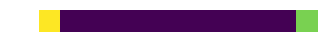

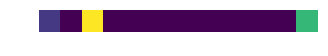

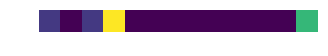

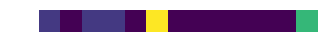

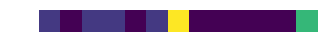

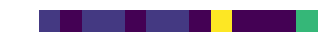

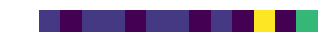

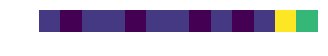

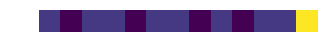

GAME OVER
Undiscounted Return : -23.0


In [4]:
undiscounted_return = 0

game = make_BoyanChain(BOYAN_CHAIN)
obs, reward, gamma = game.its_showtime()
board_footprints = show_board(obs, leave_footprints=True)
while not(game.game_over):
    obs, reward, gamma = game.play(0)
    undiscounted_return += reward
    board_footprints = show_board(obs, board_footprints, leave_footprints=True)
print('GAME OVER')
print('Undiscounted Return : {}'.format(undiscounted_return))

### Environment - Bradtke's 5-states Domain

In [4]:
BRADTKE_DOMAIN = ['P    ']

def make_BradtkeDomain(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BradtkeDomain})

class PlayerSprite_BradtkeDomain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite_BradtkeDomain, self).__init__(corner, position, character, impassable='#')
        
        self.transition_matrix = np.array([
            [0.42, 0.13, 0.14, 0.03, 0.28],
            [0.25, 0.08, 0.16, 0.35, 0.15],
            [0.08, 0.20, 0.33, 0.17, 0.22],
            [0.36, 0.05, 0.00, 0.51, 0.07],
            [0.17, 0.24, 0.19, 0.18, 0.22]
        ])
        
        self.state_features = np.array([
            [74.29, 34.61, 73.48, 53.29,  7.79],
            [61.60, 48.07, 34.68, 36.19, 82.02],
            [97.00,  4.88,  8.51, 87.89,  5.17],
            [41.10, 40.13, 64.63, 92.67, 31.09],
            [ 7.76, 79.82, 43.78,  8.56, 61.11]
        ])
        
        self.reward_matrix = np.array([
            [104.66, 29.69,  82.36,  37.49, 68.82],
            [ 75.86, 29.24, 100.37,   0.31, 35.99],
            [ 57.68, 65.66,  56.95, 100.44, 47.63],
            [ 96.23, 14.01,   0.88,  89.77, 66.77],
            [ 70.35, 23.69,  73.41,  70.70, 85.41]
        ])
    
    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.
        _, position = self.position
        
        if actions == 0: # Fake action.. just to avoid making a move during its_showtime() call

            # New position is sampled from a multinouilli distribution parametrized by the environment's transition matrix
            new_position = np.argmax(np.random.multinomial(n=1, pvals=self.transition_matrix[position, :]))
            
            # Receives a reward according to the reward matrix (deterministic reward associated with each transition)
            the_plot.add_reward(self.reward_matrix[position, new_position])
            
            # Move the agent to the new position
            self._teleport((0, new_position))

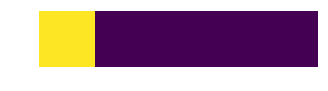

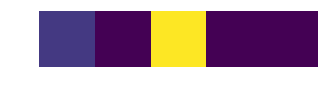

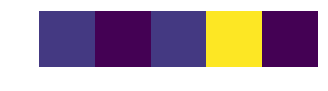

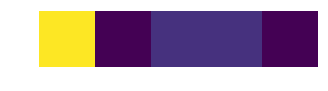

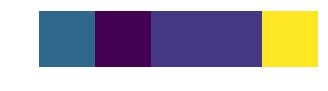

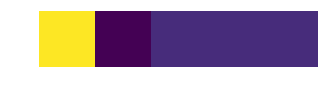

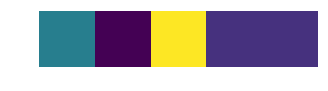

GAME OVER
Undiscounted Return : 500.56


In [6]:
undiscounted_return = 0

game = make_BradtkeDomain(BRADTKE_DOMAIN)
obs, reward, gamma = game.its_showtime()
board_footprints = show_board(obs, leave_footprints=True)

while undiscounted_return < 500:
    obs, reward, gamma = game.play(0)
    undiscounted_return += reward
    board_footprints = show_board(obs, board_footprints, leave_footprints=True)
print('GAME OVER')
print('Undiscounted Return : {:.2f}'.format(undiscounted_return))

## LSTD (in progess ...)

In [5]:
# an implementation of LSTD($\lambda$)
# given: a simulaton model, featurizer, and $\lambda$.
# output: vector $\beta$ so that $V^{\pi}(x) = \beta * \phi(x)
def _lstd(_func, _featurizer, _gamma, _lambda, n_trajectories):
    # set A = 0, b = 0, t = 0
    A, b, t = 0, 0, 0
    
    beta = np.zeros(shape=(n_trajectories, 4))
    
    #
    for n in range(n_trajectories):
        _model = _func()
        
        # choose start state $x_t$
        obs, _, __ = _model.its_showtime()
        position = np.array(obs.layers['P'])
        state = np.unravel_index(position.argmax(), position.shape)
        
        # set $z_t = \phi(x_t)$
        eligibility = _featurizer(state[1])
        
        #
        while not _model.game_over:
            # simulate one step of the chain, producing a reward R_t and next state x_{t+1}
            obs, reward, _ = _model.play(0)
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            
            #
            delta = _featurizer(state[1]) - (_gamma * _featurizer(next_state[1]))
            
            # set $A = A + z_t \cdot (\phi(x_t) - \phi(x_{t+1}))^T$
            A = A + np.dot( eligibility, delta.T )
            
            # set $b = b + z_t * R_t$
            b = b + (eligibility * reward)
            
            # set $z_{t+1} = lambda * z_t + \phi(x_{t+1})$
            eligibility = (_lambda * eligibility) + _featurizer(next_state[1])
            
            # set $t = t+1$
            t = t + 1
            
            #
            state = next_state
        
        # whenever padte coefficients are desired : set $\beta = A^{-1} \cdot b$ using SVD
        A_ = np.linalg.pinv(A)
        beta[n, :] = np.squeeze(np.dot(A_, b))
    
    return beta

In [10]:
def _r_lstd(_func, _featurizer, _gamma, _lambda, n_trajectories):
    
    theta, C, t = np.zeros([4,1]), 1000*np.ones([4, 4]), 0
    
    beta = np.zeros(shape=(n_trajectories, 4))
    
    for n in range(n_trajectories):
        _model = _func()
        
        # choose start state $x_t$
        obs, _, __ = _model.its_showtime()
        position = np.array(obs.layers['P'])
        state = np.unravel_index(position.argmax(), position.shape)
        
        # set $z_t = \phi(x_t)$
        eligibility = _featurizer(state[1])
        
        while not _model.game_over:
            # simulate one step of the chain, producing a reward R_t and next state x_{t+1}
            obs, reward, _ = _model.play(0)
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            
            #
            delta = _featurizer(state[1]) - (_gamma * _featurizer(next_state[1]))
            
            #
            L = np.dot( C, eligibility )
            K = 1. / ( 1 + np.dot(delta.T, L) )
            
            #
            e = reward - np.dot( delta.T, theta )
            theta = theta +  ( K * np.dot( C, np.dot(eligibility, e) ) )
            
            #
            C = C - (K * np.dot( C, np.dot( eligibility, np.dot(delta.T, C) ) ) )
            
            # set $z_{t+1} = lambda * z_t + \phi(x_{t+1})$
            eligibility = (_lambda * eligibility) + _featurizer(next_state[1])
        
            # set $t = t+1$
            t = t + 1
        
        beta[n, :] = np.squeeze(theta)
        
    return beta

In [8]:
# LSTD(lambda)
res = _lstd(lambda : make_BoyanChain(BOYAN_CHAIN), lambda x: boyan_features[x].reshape([-1, 1]), 1., .4)
print(res)

[[ -2.57125082e+12]
 [ -2.57125082e+12]
 [ -2.57125082e+12]
 [ -2.57125082e+12]]


In [9]:
# rLSTD(lambda)
res = _r_lstd(lambda : make_BoyanChain(BOYAN_CHAIN), lambda x: boyan_features[x].reshape([-1, 1]), 1., .4)
print(res)

[[-36676436.17896885]
 [-36676436.17896885]
 [-36676436.17896885]
 [-36676436.17896885]]


# Experiments

### 1. Comparison between off-line and recursive LSTD($\lambda$) on Boyan's Chain

5it [00:39,  7.94s/it]


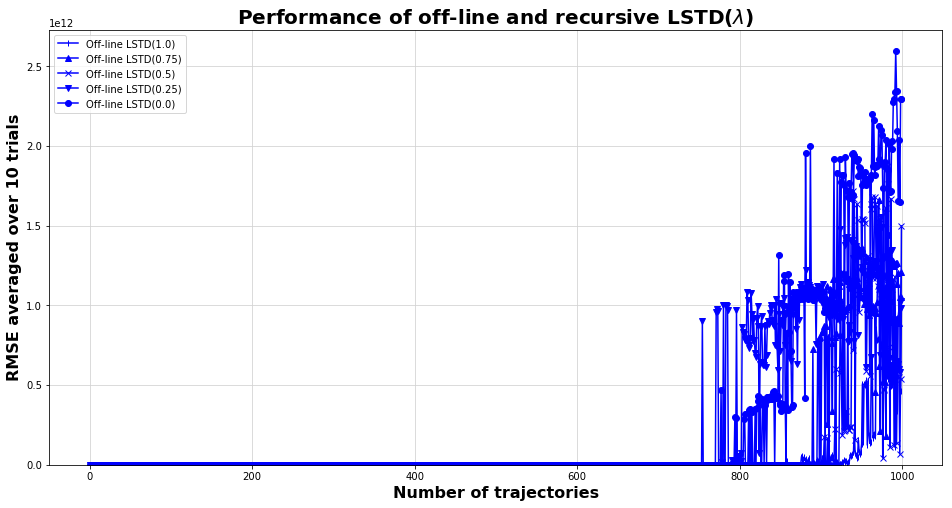

5it [00:42,  8.52s/it]


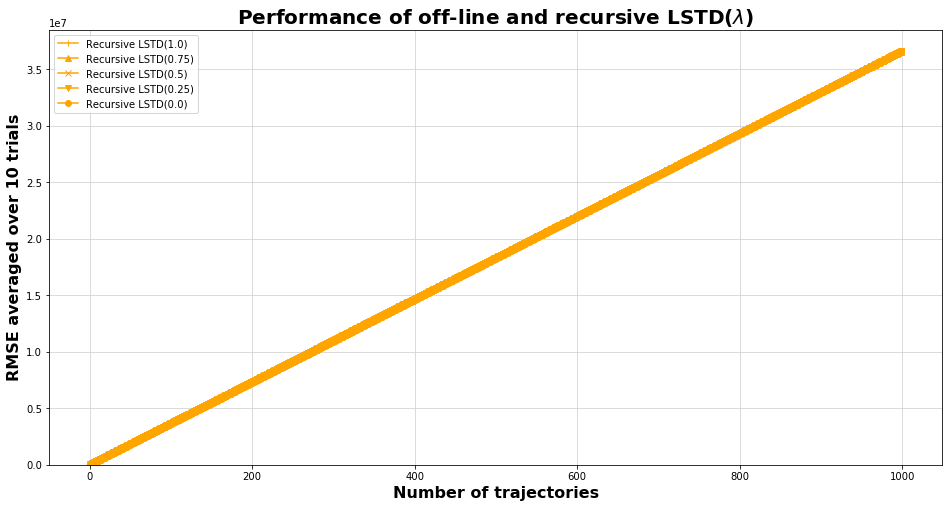

In [15]:
n_trials = 10
n_trajectories = 1000
lambdas = [1., 0.75, 0.50, 0.25, 0.]
markers = ["|", "^", "x", "v", "o"]

beta_star = np.array([-24., -16., -8., 0.])
plt.figure(figsize=(16, 8))

# Run experiments for different lambda values for the off-line algorithm
for lamda, marker in tqdm(zip(lambdas, markers)):
    
    RMSE_offline = np.zeros(shape=(n_trials, n_trajectories))
    for trial in range(n_trials):
        
        # Run one experiment for n_trajectories
        betas_offline = _lstd(lambda : make_BoyanChain(BOYAN_CHAIN), lambda x: boyan_features[x].reshape([-1, 1]), 1., .4, n_trajectories)
        
        # Computes RMS error (with respect to optimal parameters beta_star)
        RMSE_offline[trial] = np.sqrt(0.25 * np.sum((betas_offline - beta_star)**2, axis=1))
    
    # Take average of RMSE over the 10 trials
    avg_RMSE_offline = np.mean(RMSE_offline, axis=0)
        
    # plot results
    plt.plot(avg_RMSE_offline, label="Off-line LSTD({})".format(lamda), color='blue', marker=marker)

# Finalize figure
plt.title('Performance of off-line and recursive LSTD($\lambda$)', fontsize=20, fontweight='bold')
plt.xlabel('Number of trajectories', fontsize=16, fontweight='bold')
plt.ylabel('RMSE averaged over {0} trials'.format(n_trials), fontsize=16, fontweight='bold')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.ylim(bottom=0)

plt.show()
    
plt.figure(figsize=(16, 8))
# Does exactly the same thing for the recursive algorithm
for lamda, marker in tqdm(zip(lambdas, markers)):
    RMSE_recursive = np.zeros(shape=(n_trials, n_trajectories))
    for trial in range(n_trials):
        betas_recursive = _r_lstd(lambda : make_BoyanChain(BOYAN_CHAIN), lambda x: boyan_features[x].reshape([-1, 1]), 1., .4, n_trajectories)
        RMSE_recursive[trial] = np.sqrt(0.25 * np.sum((betas_recursive - beta_star)**2, axis=1))
    avg_RMSE_recursive = np.mean(RMSE_recursive, axis=0)
    plt.plot(avg_RMSE_recursive, label="Recursive LSTD({})".format(lamda), color='orange', marker=marker)
        
# Finalize figure
plt.title('Performance of off-line and recursive LSTD($\lambda$)', fontsize=20, fontweight='bold')
plt.xlabel('Number of trajectories', fontsize=16, fontweight='bold')
plt.ylabel('RMSE averaged over {0} trials'.format(n_trials), fontsize=16, fontweight='bold')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.ylim(bottom=0)

plt.show()

### 2. Comparison between off-line and recursive LSTD($\lambda$) on Bradtke's 5-states Domain

### 3. Equivalence of LSTD(1) and linear regression

In his paper, Boyan demonstrates that in the case where $\lambda=1$, the LSTD($\lambda$) algorithm produces an approximation of the value function equivalent to the one we would obtain by off-line least-square linear regression. The linear regression method here is a simple supervised approach that learns to approximate the expected return for each state from Monte-Carlo returns of sampled trajectories.

In this experiment we empirically verify this claim by numerically comparing the value function produced by those two methods.

In [17]:
def build_dataset():
    """
    Samples a single trajectory and returns a training set (states, returns) that contain (x,y) values for each timestep
    """
    game = make_BoyanChain(BOYAN_CHAIN)
    obs, reward, gamma = game.its_showtime()

    states = []
    rewards = []
    while not(game.game_over):    

        # Stores current state (because it's not terminal)
        agent_mask = np.array(obs.layers['P'])
        position = np.unravel_index(agent_mask.argmax(), agent_mask.shape)
        state = boyan_features[position[1]]
        states.append(state)

        # Do one transition and stores the reward
        obs, reward, gamma = game.play(0)
        rewards.append(reward)

    L = len(rewards)
        
    rewards = np.array(rewards)
    returns = np.zeros_like(rewards)
    states = np.array(states)

    # Computes return for every timestep
    for t in range(L):
        returns[t] = np.sum(rewards[t:])
    print(type(states))
    
    return states, returns

In [18]:
np.random.seed(1234)
x, y = build_dataset()
L = x.shape[0] # The lenghth of the trajectory

A_LR = 0
b_LR = 0
for t in range(L):
    A_LR += np.outer(x[t,:], x[t,:].T)
    b_LR += x[t,:] * y[t]

print(A_LR)
print(b_LR)

<class 'numpy.ndarray'>
[[ 1.3125  0.4375  0.      0.    ]
 [ 0.4375  1.6875  0.625   0.    ]
 [ 0.      0.625   1.5     0.375 ]
 [ 0.      0.      0.375   0.625 ]]
[-37.25 -40.75 -19.25  -2.75]


In [20]:
A_inv = np.linalg.pinv(A_LR)
beta = np.dot(A_inv, b_LR)
print(beta)

[-23.06349206 -15.95238095  -5.98412698  -0.80952381]


# Discussion

# Conclusion